Taylor Salo

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import brian2 as br
import pylab as plt
import seaborn as sns

sns.set_style('darkgrid')
palette = sns.light_palette('purple', 10)[::2]
plt.rcParams['figure.figsize'] = [12, 8]

# Question 1

In [1]:
def run_q1(input_current, tau_decay=2*br.ms, E_syn=0*br.mV):
    # define parameters of the LIF model
    R = 100 * br.Mohm  # membrane resistance
    tau = 10 * br.ms  # membrane time constant
    thr = -50 * br.mV  # spike threshold
    u_rest = -65 * br.mV  # resting potential
    u_r = -70 * br.mV  # reset potential
    
    # define parameters of the synapse model
    g_jump = 10 * br.nsiemens  # jump in conductivity
                               # after a presynaptic spike

    # define equation for the LIF model
    # and equation for the synapse model
    eqs = '''
    du/dt = ( -(u - u_rest) + R*I - R*I_syn ) / tau : volt
    I = input_current(t,i) : amp
    I_syn = g_syn*(u - E_syn): amp
    dg_syn/dt = -g_syn / tau_decay : siemens
    '''

    # create neuron group
    br.start_scope()
    LIF = br.NeuronGroup(2, eqs, threshold='u>thr',
                         reset='u=u_r', method='euler')

    # set membrane to resting potential
    LIF.u[:] = u_rest

    # create synapse
    S = br.Synapses(LIF, on_pre='g_syn += g_jump')
    S.connect(i=0, j=1)

    # indicate what to record
    rec = br.StateMonitor(LIF, ('I', 'u', 'I_syn', 'g_syn'),
                          record=True)

    # run the simulation for 200 ms
    br.run(200 * br.ms)
    
    # Plot membrane potential against time for LIF neurons.
    fig, axes = plt.subplots(3, sharex=True)
    fig.suptitle('A Single LIF Synapse', fontsize=20)
    axes[0].plot(rec.t/br.ms, rec.u[0]*1000, 'b--',
                 label='Presynaptic Neuron', lw=3.)
    axes[0].plot(rec.t/br.ms, rec.u[1]*1000, 'r',
                 label='Postsynaptic Neuron', lw=3.)
    axes[0].set_title('Membrane Potentials')
    axes[0].set_ylabel('Membrane potential (mV)')
    axes[0].set_ylim((-71, -49))
    
    legend = axes[0].legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    # plot the synaptic conductivity
    axes[1].plot(rec.t/br.ms, rec.g_syn[1]*10**9, 'r')
    axes[1].set_ylabel('Membrane conductivity (nS)')
    axes[1].set_title('Postsynaptic Conductivity (g_syn)')
    axes[1].set_ylim((-2, 12))
    
    # plot the post-synaptic current
    axes[2].plot(rec.t/br.ms, rec.I_syn[1]*10**12, 'r')
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_title('Postsynaptic Current')
    axes[2].set_ylabel('Postsynaptic current (pA)')
    axes[2].set_ylim((-700, 100))
    plt.show(fig)

NameError: name 'br' is not defined

### Set Esyn to 0

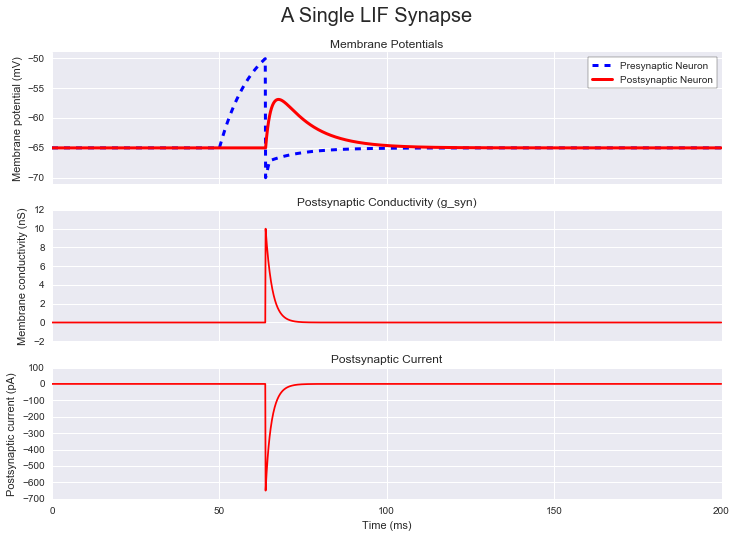

In [3]:
# Create input array.
# First neuron receives 200 pA from t = 51 to 65
input_current = np.zeros((200, 2))
input_current[50:65, 0] = 200
input_current = br.TimedArray(input_current*br.pamp,
                              dt=1*br.ms)

tau_decay = 2 * br.ms
E_syn = 0 * br.mV

run_q1(input_current, tau_decay, E_syn)

### Set Esyn to -60

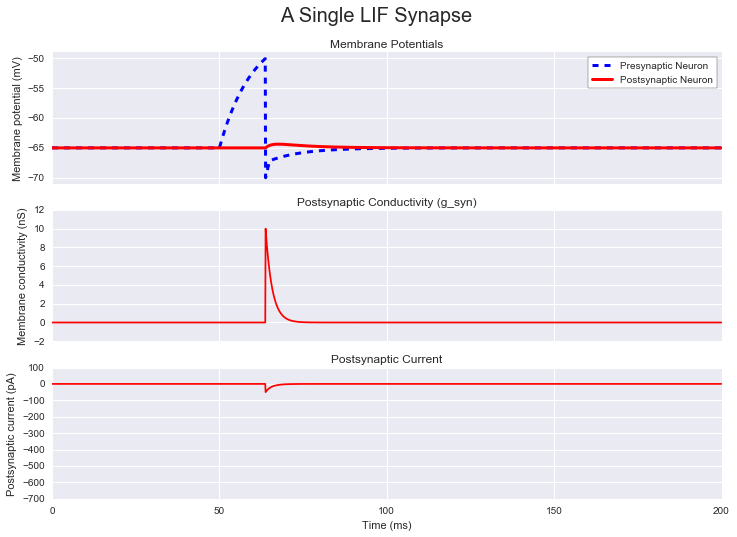

In [4]:
# Create input array.
# First neuron receives 200 pA from t = 51 to 65
input_current = np.zeros((200, 2))
input_current[50:65, 0] = 200
input_current = br.TimedArray(input_current*br.pamp,
                              dt=1*br.ms)

tau_decay = 2 * br.ms
E_syn = -60 * br.mV

run_q1(input_current, tau_decay, E_syn)

## Part A
In the first simulation, the spike from the presynaptic neuron causes a large excitatory potential in the postsynaptic neuron. In the second simulation, the equilibrium potential of the synaptic channels is set to -60, which results in very little change in the postsynaptic membrane potential after the spike.

## Part B
The postsynaptic current drops from zero to about -650 pA when E_syn is set to 0 mV, but only drops to about -50 pA when E_syn is set to -60 mV. At -60 mV, there is no net ion flow at the postsynaptic membrane, which means that the membrane potential cannot increase beyond -60, even when there is a presynaptic action potential. The postsynaptic current reflects the movement of the ions across the membrane.

## Part C
There would be no postynaptic current or potential if E_syn was set to the resting potential, -65 mV. The postsynaptic conductivity would stay the same (i.e., jump to 10 nS and degrade after) even if E_syn was changed.

# Question 2

In [5]:
def run_q2(input_current):
    # define parameters of the LIF model
    R = 100 * br.Mohm  # membrane resistance
    tau = 10 * br.ms  # membrane time constant
    thr = -50 * br.mV  # spike threshold
    u_rest = -65 * br.mV  # resting potential
    u_r = -70 * br.mV  # reset potential
    
    # AMPA-specific parameters
    E_AMPA = 0 * br.mV  # equilibrium potential for AMPA channels
    tau_AMPA = 2 * br.ms  # time constraint for AMPA channels
    g_jump_AMPA = 17 * br.nsiemens  # jump for the AMPA chanenels
    
    # GABA-specific parameters
    E_GABA = -70 * br.mV  # equilibrium potential for GABA channels
    tau_GABA = 12 * br.ms  # time constraint for GABA channels
    g_jump_GABA = 17 * br.nsiemens  # jump for the GABA chanenels

    # define equation for the LIF model
    # and equation for the synapse model
    eqs = '''
    du/dt = ( -(u - u_rest) + R*I - R*(I_AMPA+I_GABA) ) / tau : volt
    I = input_current(t, i) : amp
    I_AMPA = g_AMPA*(u - E_AMPA): amp
    I_GABA = g_GABA*(u - E_GABA): amp
    dg_AMPA/dt = -g_AMPA / tau_AMPA : siemens
    dg_GABA/dt = -g_GABA / tau_GABA : siemens
    '''

    # create neuron group
    br.start_scope()
    LIF = br.NeuronGroup(2, eqs, threshold='u>thr',
                         reset='u=u_r', method='euler')

    # set membrane to resting potential
    LIF.u[:] = u_rest

    # create excitatory synapse from neuron 0 to neuron 1
    E = br.Synapses(LIF, on_pre='g_AMPA += g_jump_AMPA')
    E.connect(i=0, j=1)
    
    # create inhibitory synapse from neuron 1 to neuron 0
    I = br.Synapses(LIF, on_pre='g_GABA += g_jump_GABA')
    I.connect(i=1, j=0)

    # indicate what to record
    rec = br.StateMonitor(LIF, ('I', 'u'), record=True)

    # run the simulation for 200 ms
    br.run(200 * br.ms)
    
    # Plot membrane potential against time for LIF neurons.
    fig, ax = plt.subplots()
    fig.suptitle('Two LIF Synapses (FW=AMPA, RV=GABA)',
                 fontsize=20)
    ax.plot(rec.t/br.ms, rec.u[0]*1000, 'b--', label='Neuron 0',
            lw=3.)
    ax.plot(rec.t/br.ms, rec.u[1]*1000, 'r', label='Neuron 1',
            lw=3.)
    ax.set_ylabel('Membrane potential (mV)')
    ax.set_xlabel('Time (ms)')
    ax.set_ylim((-71, -49))
    
    legend = ax.legend(frameon=True, loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    plt.show(fig)

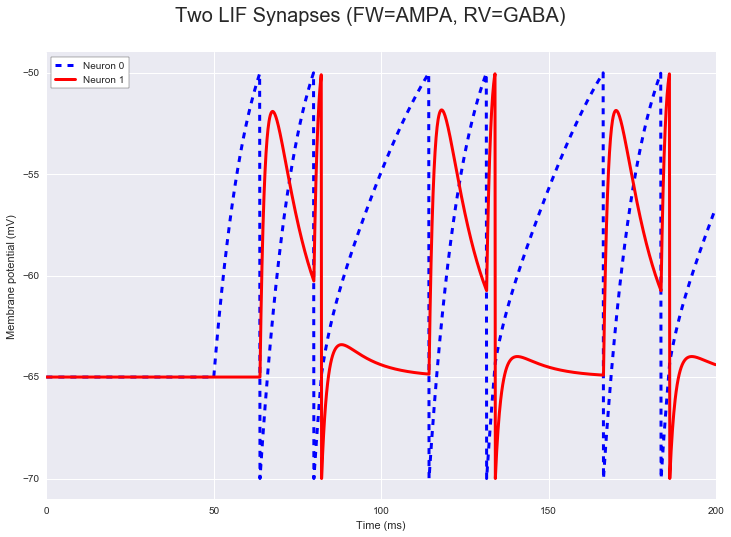

In [6]:
# Create input array.
# First neuron receives 200 pA from t = 51 to the end
input_current = np.zeros((200, 2))
input_current[50:, 0] = 200
input_current = br.TimedArray(input_current*br.pamp, dt=1*br.ms)

run_q2(input_current)

## Part A
Unlike a typical LIF neuron with a constant manual input of 200 pA, neuron 0 in this simulation does not spike regularly. Instead, the spike rate varies systematically, due to spiking of neuron 1. Each time neuron 1 spikes, this inhibits neuron 0, momentarily decreasing the rate at which it can spike from the constant input.

## Part B
Neuron 1 spikes for each second spike in neuron 0. Two action potentials in neuron 0 are sufficient to excite neuron 1 into firing an action potential. 

## Part C
Neuron 0 is inhibited by action potentials in neuron 1. Since neuron 1 only fires once for each two times neuron 0 fires, the firing of neuron 0 effectively decreases the spike rate of neuron 1. This is similar to the adaptation modeled in AdEx, which prevents the neuron from firing at a constant rate under a constant input.